# Лабораторная работа 2. Визуализация градиентного спуска. Ландшафты потерь. Оптимайзеры.



In [ ]:
# готовим функцию для красивой отрисовки градиента
import numpy as np
import matplotlib.pyplot as plt

def show_contours(objective,
                  x_lims=[-200.0, 202.0],
                  y_lims=[-200.0, 202.0],
                  x_ticks=100,
                  y_ticks=100):
    x_step = (x_lims[1] - x_lims[0]) / x_ticks
    y_step = (y_lims[1] - y_lims[0]) / y_ticks
    X, Y = np.mgrid[x_lims[0]:x_lims[1]:x_step, y_lims[0]:y_lims[1]:y_step]
    res = []
    for x_index in range(X.shape[0]):
        res.append([])
        for y_index in range(X.shape[1]):
            x_val = X[x_index, y_index]
            y_val = Y[x_index, y_index]
            res[-1].append(objective(np.array([[x_val, y_val]]).T))
    res = np.array(res)
    plt.figure(figsize=(7,7))
    plt.contour(X, Y, res, 100)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

In [ ]:
# расcчитаем градиентный спуск для фунции для 10 cумма(x^2), x = тензор 1 на 2. Инициализирован значением 8
import torch

# тензор
x = torch.tensor(
    [200.,200.], requires_grad=True)

# сюда будем складывать значения тензора x при каждом шаге градиентного спуска
var_history = []

# сюда будем складывать значения функции при каждом шаге градиентного спуска
fn_history = []

# определяем функцию.
def function_parabola(variable):
    return 10 * (variable ** 2).sum()

# считаем шаг градиентного спуска
lr = 0.01
def make_gradient_step(function, variable):
    function_result = function(variable)
    function_result.backward()
    variable.data -= lr * variable.grad
    variable.grad.zero_()

# реализуем градиентный спуск, думаем, что за 500 шагов справимся, и найдем минимум функции.
for i in range(500):
    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_parabola(x).data.cpu().numpy().copy())
    make_gradient_step(function_parabola, x)

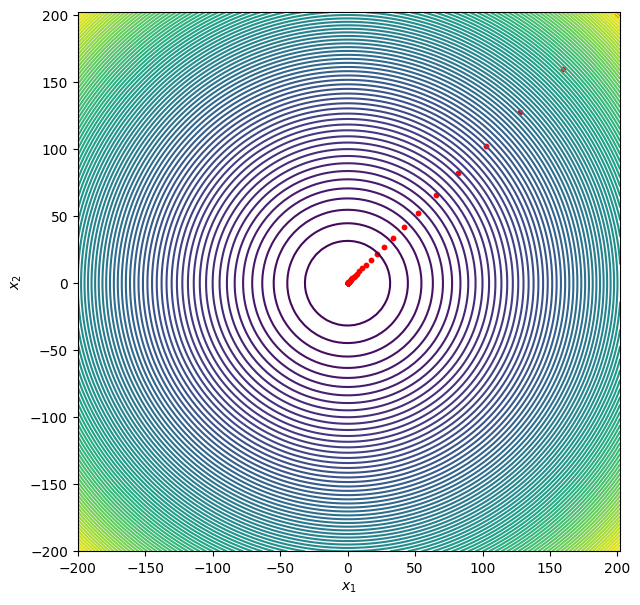

In [ ]:
show_contours(function_parabola)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

## Задание 1. Сделайте трехмерную визуализацию сходимости градиентного спуска. Нарисуйте поверхность функции двух переменных для которой осуществлялся поиск минимума методом градиентного спуска. Отдельными точками другого цвета изобразите позиции которые рассматривались на каждом шаге градиентного спуска.

In [ ]:
from matplotlib import cm

def show_contours3d(
                  x_lims=[-200.0, 202.0],
                  y_lims=[-200.0, 202.0],
                  z_lims=[-200.0, 202.0],
                  x_ticks=100,
                  y_ticks=100,
                  z_ticks=100):
    x_step = (x_lims[1] - x_lims[0]) / x_ticks
    y_step = (y_lims[1] - y_lims[0]) / y_ticks
    z_step = (z_lims[1] - z_lims[0]) / z_ticks
    X, Y = np.mgrid[x_lims[0]:x_lims[1]:x_step, y_lims[0]:y_lims[1]:y_step]
    t = np.mgrid[x_lims[0]:x_lims[1]:x_step, y_lims[0]:y_lims[1]:y_step]

    Z = (10 * (X**2 + Y**2))

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection = '3d')
    surf = ax.plot_surface(X, Y, Z, alpha=0.5, cmap='magma')
    ax.view_init(45, 150)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], np.array(fn_history), color='black');

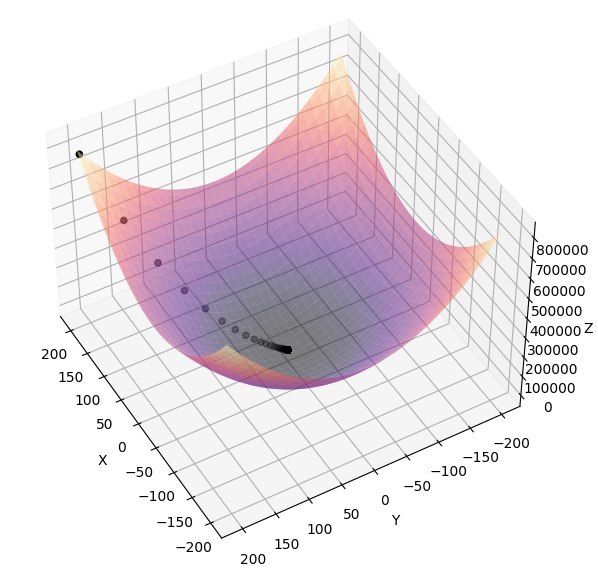

In [ ]:
show_contours3d()

## Задание 2. Для своего кода лабораторной работы №1 примените три разных оптимайзера. Постройте графики зависимости величины функции потерь от номера эпохи для всех трех оптимайзеров на одном графике сначала для обучающей выборки, потом для тестовой.

In [7]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [8]:
import torchvision.datasets

In [9]:
EMNIST_train = torchvision.datasets.EMNIST('./', download=True, train=True, split='letters')
EMNIST_test = torchvision.datasets.EMNIST('./', download=True, train=False, split='letters')

100%|██████████| 561753746/561753746 [00:04<00:00, 122521034.01it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [12]:
# формируем датасеты для обучения, тестирования, целевые переменные
X_train = EMNIST_train.train_data
y_train = EMNIST_train.train_labels
X_test = EMNIST_test.test_data
y_test = EMNIST_test.test_labels

In [13]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [56]:
# Определяем класс, которые и будет представлять нашу нейронку

class LeNet5(torch.nn.Module):
    # конструктор. Определям вообще какие слои у нас будут
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # используем ReLU в качестве функции активации
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(84, 37)

    # наша самая главная функция. Определяем, что и в каком порядке будет вызываться
    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lenet5 = lenet5.to(device)

In [58]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

Возьмём 3 оптимизатора
* SGD (Stochastic Gradient Descent)
* RMSprop (Root Mean Squared Propagation)
* AdamW (Adam with Weight Decay)

In [72]:
lable_opt = ['Stochastic Gradient Descent', 'Root Mean Squared Propagation', 'Adam with Weight Decay']

In [73]:
optimizer_sgd = torch.optim.SGD(lenet5.parameters(), lr=1.0e-3, momentum=0.9)

optimizer_rms = torch.optim.RMSprop(lenet5.parameters(), lr=1.0e-3, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)

optimizer_adamw = torch.optim.AdamW(lenet5.parameters(), lr=1.0e-3, weight_decay=0.01)

optimizers = [optimizer_sgd, optimizer_rms, optimizer_adamw]

In [74]:
train_loss_history_sgd = []
test_loss_history_sgd = []

train_loss_history_rms = []
test_loss_history_rms = []

train_loss_history_adamw = []
test_loss_history_adamw = []

train_loss_history_arr = [train_loss_history_sgd, train_loss_history_rms, train_loss_history_adamw]
test_loss_history_arr = [test_loss_history_sgd, test_loss_history_rms, test_loss_history_adamw]

In [75]:
def start(optimizer, test_loss_history, train_loss_history, X_train, y_train, X_test, y_test):
  # будем оптимизировать по 100 параметров одним комплектом (бачем)
  batch_size = 100

  # чтобы посмотреть, как и что у нас тут менялось при оптимизации на тестовой выборке
  test_accuracy_history = []

  # не забываем отправить все выборки на устройство, на котором обучаем
  X_test = X_test.to(device)
  y_test = y_test.to(device)

  for epoch in range(20):
      order = np.random.permutation(len(X_train))
      for start_index in range(0, len(X_train), batch_size):
          # обязательно обнуляем градиенты
          optimizer.zero_grad()

          # берем пачку параметров
          batch_indexes = order[start_index:start_index+batch_size]

          X_batch = X_train[batch_indexes].to(device)
          y_batch = y_train[batch_indexes].to(device)

          # делаем предсказание
          preds = lenet5.forward(X_batch)

          # считаем лосс значение
          loss_value = loss(preds, y_batch)

          # берем градиенты
          loss_value.backward()

          # и пусть оптимайзер все оптимизирует
          optimizer.step()

      # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
      train_loss_history.append(loss_value.data.cpu())

      test_preds = lenet5.forward(X_test)
      test_loss_history.append(loss(test_preds, y_test).data.cpu())


      accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
      test_accuracy_history.append(accuracy)

      print(f"epoch{epoch} - accuracy test {accuracy} ")

In [76]:
#обучем с помощью всех оптимезаторов
for index, opt in enumerate(optimizers):
  print(lable_opt[index] + ' start')
  print('-' * 50)
  start(X_test=X_test, y_test=y_test, X_train=X_train, y_train=y_train,
      optimizer=opt, train_loss_history=train_loss_history_arr[index],
        test_loss_history=test_loss_history_arr[index])

Stochastic Gradient Descent start
--------------------------------------------------
epoch0 - accuracy test 0.9327403903007507 
epoch1 - accuracy test 0.9323077201843262 
epoch2 - accuracy test 0.9324519038200378 
epoch3 - accuracy test 0.9311057925224304 
epoch4 - accuracy test 0.9325481057167053 
epoch5 - accuracy test 0.9329326748847961 
epoch6 - accuracy test 0.9311538338661194 
epoch7 - accuracy test 0.9309134483337402 
epoch8 - accuracy test 0.9325481057167053 
epoch9 - accuracy test 0.9315865635871887 
epoch10 - accuracy test 0.9316827058792114 
epoch11 - accuracy test 0.9302884340286255 
epoch12 - accuracy test 0.9312499761581421 
epoch13 - accuracy test 0.9318749904632568 
epoch14 - accuracy test 0.9310576915740967 
epoch15 - accuracy test 0.931538462638855 
epoch16 - accuracy test 0.9301442503929138 
epoch17 - accuracy test 0.932115375995636 
epoch18 - accuracy test 0.9298557639122009 
epoch19 - accuracy test 0.9299519062042236 
Root Mean Squared Propagation start
-----------

<ipython-input-77-30722a64c854>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d
<ipython-input-77-30722a64c854>:5: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


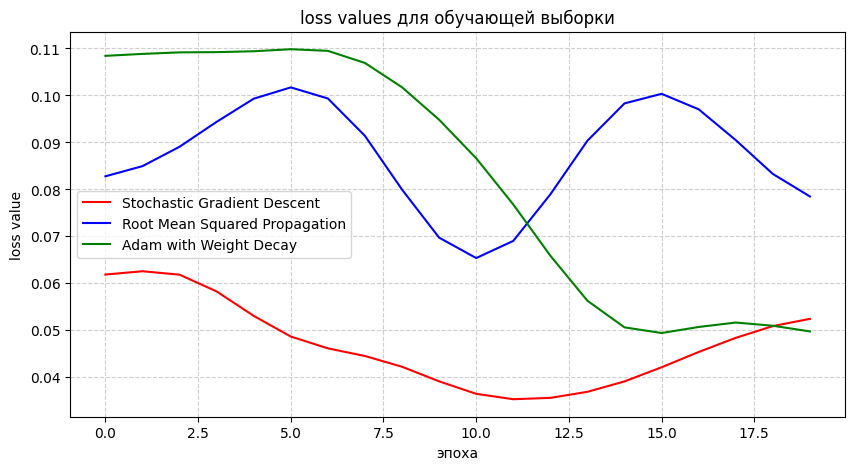

In [77]:
# строим графики - функции потерь обучающей выборки
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d

color = ['red', 'blue', 'green']

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set(title = 'loss values для обучающей выборки',
       xlabel = 'эпоха',
       ylabel = 'loss value')
for i in range(3):
  train_loss_smoothed = gaussian_filter1d(train_loss_history_arr[i], sigma=2)
  ax.plot(train_loss_smoothed, color=color[i],  label=lable_opt[i])


ax.legend()
plt.show()

<ipython-input-78-b926afd1c273>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d
<ipython-input-78-b926afd1c273>:5: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


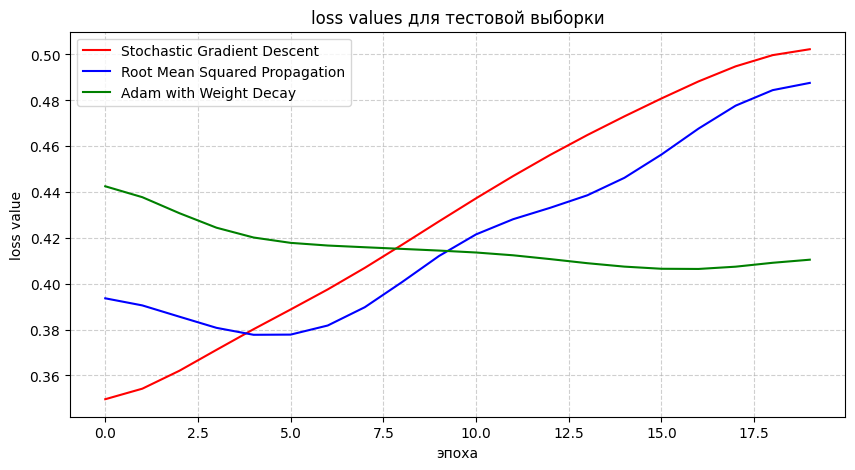

In [78]:
# строим графики - функции потерь тестовой выборки
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d

color = ['red', 'blue', 'green']

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set(title = 'loss values для тестовой выборки',
       xlabel = 'эпоха',
       ylabel = 'loss value')
for i in range(3):
  train_loss_smoothed = gaussian_filter1d(test_loss_history_arr[i], sigma=2)
  ax.plot(train_loss_smoothed, color=color[i],  label=lable_opt[i])


ax.legend()
plt.show()

## Задание 3. Изучите статью https://habr.com/ru/companies/skillfactory/articles/536606/. Попробуйте воспроизвести ее результаты в своем коде. Если не получится сделать анимацию, можно те же графики оставить статическими.

In [4]:
import numpy as np
import gzip
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import expit
from matplotlib import animation

In [14]:
X_train = EMNIST_train.data.float().view(-1, 28 * 28) / 255.0  # Преобразуем в векторы и нормализуем
y_train = EMNIST_train.targets

X_test = EMNIST_test.data
y_test = EMNIST_test.targets

In [15]:
X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [16]:
from sklearn.preprocessing import OneHotEncoder

oh=OneHotEncoder(categories='auto')
y_train_oh=oh.fit_transform(y_train.reshape(-1,1)).toarray() # one-hot-encoding of y-values

In [2]:
hidden_0=50 # number of nodes of first hidden layer
hidden_1=500 # number of nodes of second hidden layer

# Set up cost function:
def costs(x,y,w_a,w_b,seed_):
        np.random.seed(seed_) # insert random seed
        w0=np.random.randn(hidden_0,784)  # weight matrix of 1st hidden layer
        w1=np.random.randn(hidden_1,hidden_0) # weight matrix of 2nd hidden layer
        w2=np.random.randn(26,hidden_1) # weight matrix of output layer
        w2[5][250] = w_a # set value for weight w_250,5(2)
        w2[5][251] = w_b # set value for weight w_251,5(2)
        a0 = expit(w0 @ x.T)  # output of 1st hidden layer
        a1=expit(w1 @ a0)  # output of 2nd hidden layer
        pred= expit(w2 @ a1) # output of final layer
        return np.mean(np.sum((y-pred)**2,axis=0)) # costs w.r.t. w_a and w_b

<ipython-input-189-ed591064f4d5>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w2[5][250] = w_a # set value for weight w_250,5(2)
<ipython-input-189-ed591064f4d5>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w2[5][251] = w_b # set value for weight w_251,5(2)


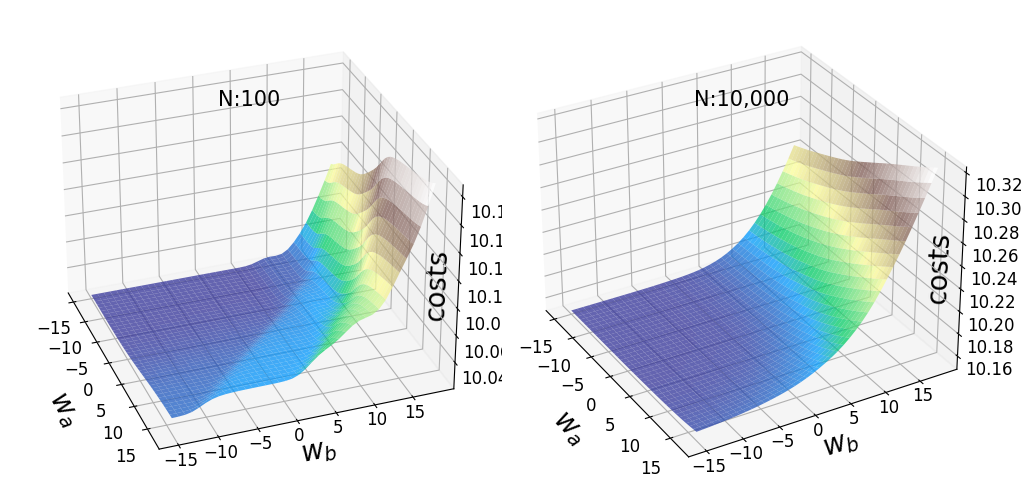

In [190]:
# Set range of values for meshgrid:
m1s = np.linspace(-15, 17, 40)
m2s = np.linspace(-15, 18, 40)
M1, M2 = np.meshgrid(m1s, m2s) # create meshgrid

# Determine costs for each coordinate in meshgrid:
zs_100 = np.array([costs(X_train[0:100],y_train_oh[0:100].T
                               ,np.array([[mp1]]), np.array([[mp2]]),135)
                       for mp1, mp2 in zip(np.ravel(M1), np.ravel(M2))])
Z_100 = zs_100.reshape(M1.shape) # z-values for N=100

zs_10000 = np.array([costs(X_train[0:10000],y_train_oh[0:10000].T
                               ,np.array([[mp1]]), np.array([[mp2]]),135)
                       for mp1, mp2 in zip(np.ravel(M1), np.ravel(M2))])
Z_10000 = zs_10000.reshape(M1.shape) # z-values for N=10,000


# Plot loss landscapes:
fig = plt.figure(figsize=(10,7.5)) # create figure
ax0 = fig.add_subplot(121, projection='3d' )
ax1 = fig.add_subplot(122, projection='3d' )

fontsize_=20 # set axis label fontsize
labelsize_=12 # set tick label size

# Customize subplots:
ax0.view_init(elev=30, azim=-20)
ax0.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=9)
ax0.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=-5)
ax0.set_zlabel("costs", fontsize=fontsize_, labelpad=-30)
ax0.tick_params(axis='x', pad=5, which='major', labelsize=labelsize_)
ax0.tick_params(axis='y', pad=-5, which='major', labelsize=labelsize_)
ax0.tick_params(axis='z', pad=5, which='major', labelsize=labelsize_)
ax0.set_title('N:100',y=0.85,fontsize=15) # set title of subplot

ax1.view_init(elev=30, azim=-30)
ax1.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=9)
ax1.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=-5)
ax1.set_zlabel("costs", fontsize=fontsize_, labelpad=-30)
ax1.tick_params(axis='y', pad=-5, which='major', labelsize=labelsize_)
ax1.tick_params(axis='x', pad=5, which='major', labelsize=labelsize_)
ax1.tick_params(axis='z', pad=5, which='major', labelsize=labelsize_)
ax1.set_title('N:10,000',y=0.85,fontsize=15)

# Surface plots of costs (= loss landscapes):
ax0.plot_surface(M1, M2, Z_100, cmap='terrain', #surface plot
                             antialiased=True,cstride=1,rstride=1, alpha=0.75)
ax1.plot_surface(M1, M2, Z_10000, cmap='terrain', #surface plot
                             antialiased=True,cstride=1,rstride=1, alpha=0.75)
plt.tight_layout()
plt.show()

In [218]:
# Store values of costs and weights in lists:
weights_2_5_250=[]
weights_2_5_251=[]
costs=[]

seed_= 135 # random seed
N=100 # sample size

# Set up neural network:
class NeuralNetwork(object):
    def __init__(self, lr=0.01):
        self.lr=lr
        np.random.seed(seed_) # set random seed
        # Intialize weight matrices:
        self.w0=np.random.randn(hidden_0,784)
        self.w1=np.random.randn(hidden_1,hidden_0)
        self.w2=np.random.randn(26,hidden_1)
        self.w2[5][250] = start_a # set starting value for w_a
        self.w2[5][251] = start_b # set starting value for w_b

    def train(self, X,y):
        a0 = expit(self.w0 @ X.T)
        a1=expit(self.w1 @ a0)
        pred= expit(self.w2 @ a1)
        # Partial derivatives of costs w.r.t. the weights of the output layer:
        dw2= (pred - y.T)*pred*(1-pred)  @ a1.T / len(X)   # ... averaged over the sample size
        # Update weights:
        self.w2[5][250]=self.w2[5][250] - self.lr * dw2[5][250]
        self.w2[5][251]=self.w2[5][251] - self.lr * dw2[5][251]
        costs.append(self.cost(pred,y)) # append cost values to list

    def cost(self, pred, y):
        return np.mean(np.sum((y.T-pred)**2,axis=0))

# Initial values of w_a/w_b:
starting_points = [  (5,15),(0,15),(10,15)]

for j in starting_points:
    start_a,start_b=j
    model=NeuralNetwork(10) # set learning rate to 10
    for i in range(10000):  # 10,000 epochs
        model.train(X_train[0:N], y_train_oh[0:N])
        weights_2_5_250.append(model.w2[5][250]) # append weight values to list
        weights_2_5_251.append(model.w2[5][251]) # append weight values to list

# Create sublists of costs and weight values for each starting point:
costs = np.split(np.array(costs),3)
weights_2_5_250 = np.split(np.array(weights_2_5_250),3)
weights_2_5_251 = np.split(np.array(weights_2_5_251),3)

In [192]:
print("Final values:")
print("Weights_2_5_250:", weights_2_5_250)
print("Weights_2_5_251:", weights_2_5_251)
print("Costs:", costs)

Final values:
Weights_2_5_250: [array([ -9.01219336,  -9.02479132,  -9.03779282, ..., -13.66605484,
       -13.6662984 , -13.66654195]), array([-10.11642729, -10.13289299, -10.14932974, ..., -13.96760701,
       -13.96783292, -13.96805882]), array([-11.0138186 , -11.02709803, -11.0398207 , ..., -14.27236819,
       -14.27257795, -14.2727877 ])]
Weights_2_5_251: [array([14.9349277 , 14.87000201, 14.80522176, ..., 10.38649336,
       10.38649466, 10.38649596]), array([14.93066182, 14.86190669, 14.79380015, ..., 10.38806558,
       10.38806673, 10.38806788]), array([14.93346382, 14.86810193, 14.80392375, ..., 10.38957517,
       10.38957618, 10.38957719])]
Costs: [array([10.06289319, 10.06201703, 10.06114265, ..., 10.02725974,
       10.02725972, 10.02725971]), array([10.0596589 , 10.05864725, 10.05765198, ..., 10.02724559,
       10.02724557, 10.02724556]), array([10.05683751, 10.05592241, 10.05504115, ..., 10.02723231,
       10.02723231, 10.0272323 ])]


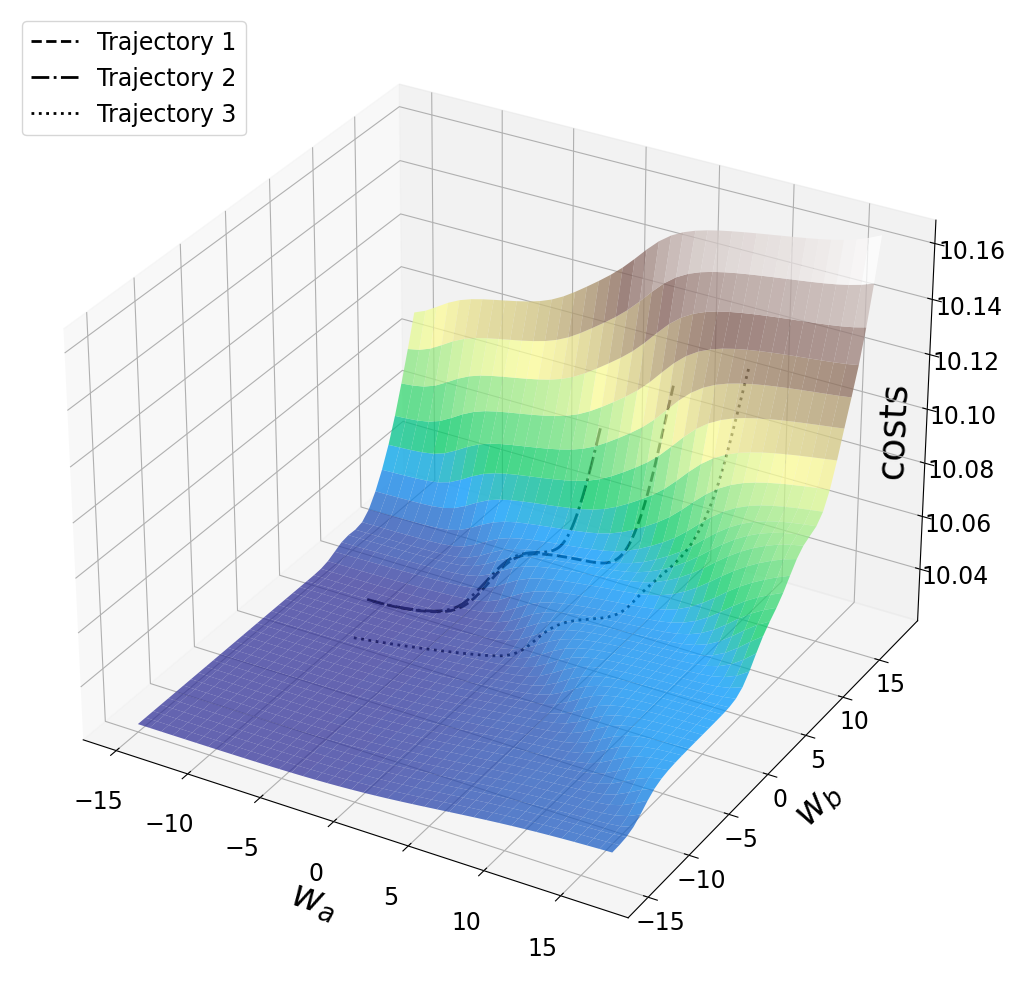

In [223]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Устанавливаем метки осей
ax.set_xlabel(r'$w_a$', fontsize=27, labelpad=17)
ax.set_ylabel(r'$w_b$', fontsize=27, labelpad=5)
ax.set_zlabel("costs", fontsize=27, labelpad=-35)
ax.tick_params(axis='x', pad=12, which='major', labelsize=17)
ax.tick_params(axis='y', pad=0, which='major', labelsize=17)
ax.tick_params(axis='z', pad=8, which='major', labelsize=17)


# Строим поверхность (loss landscape)
ax.plot_surface(M1, M2, Z_100, cmap='terrain', antialiased=True, cstride=1, rstride=1, alpha=0.75)

# Строим траектории градиентного спуска
line_style = ["dashed", "dashdot", "dotted"]  # Линии для траекторий
for j in range(3):  # Проходим по каждой траектории
    ax.plot(weights_2_5_250[j], weights_2_5_251[j], costs[j],
            linestyle=line_style[j], linewidth=2, color="black", label=f'Trajectory {j+1}')


# Отображаем легенду
ax.legend(loc='upper left', fontsize=17)
plt.tight_layout()
plt.show()

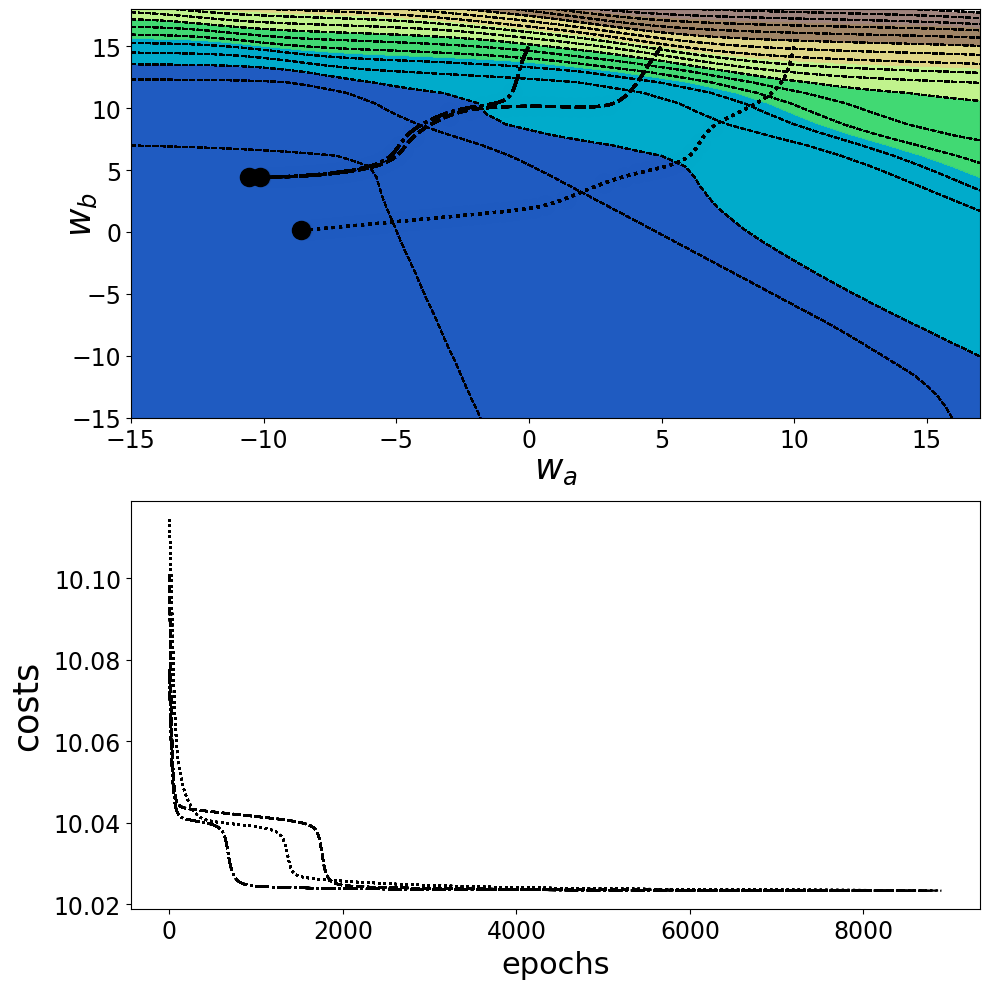

In [220]:
fig = plt.figure(figsize=(10,10)) # create figure
ax0=fig.add_subplot(2, 1, 1)
ax1=fig.add_subplot(2, 1, 2)

# Customize subplots:
ax0.set_xlabel(r'$w_a$', fontsize=25, labelpad=0)
ax0.set_ylabel(r'$w_b$', fontsize=25, labelpad=-20)
ax0.tick_params(axis='both', which='major', labelsize=17)
ax1.set_xlabel("epochs", fontsize=22, labelpad=5)
ax1.set_ylabel("costs", fontsize=25, labelpad=7)
ax1.tick_params(axis='both', which='major', labelsize=17)

contours_=21 # set the number of contour lines
points_=np.arange(0,9000,100) # define which epochs to plot

for i in points_:
    cf=ax0.contour(M1, M2, Z_100,contours_, colors='black', # contour plot
                     linestyles='dashed', linewidths=1)
    ax0.contourf(M1, M2, Z_100, alpha=0.85,cmap='terrain') # filled contour plots

    for j in range(3):
        ax0.scatter(weights_2_5_250[j][i],weights_2_5_251[j][i],marker='o', s=13**2,
               color="black", alpha=1.0)
        ax0.plot(weights_2_5_250[j][0:i],weights_2_5_251[j][0:i],
                linestyle=line_style[j],linewidth=2,
                color="black", label=str(i))

        ax1.plot(costs[j][0:i], color="black", linestyle=line_style[j])
    plt.tight_layout()




## Задание 4. В коде, полученном после выполнения задания 3, релизуйте по формулам один из оптимайзеров. Как изменится визуализация поиска минимума из тех же трех точек?

In [ ]:
import numpy as np
from scipy.special import expit  # Функция сигмоиды для активации

# Store values of costs and weights in lists
weights_2_5_250 = []
weights_2_5_251 = []
costs = []

seed_ = 135  # random seed
N = 100  # sample size

# Set up neural network
class NeuralNetwork(object):
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1  # Коэффициент для первого момента
        self.beta2 = beta2  # Коэффициент для второго момента
        self.epsilon = epsilon  # Небольшое значение для предотвращения деления на ноль
        np.random.seed(seed_)

        # Initialize weight matrices
        self.w0 = np.random.randn(hidden_0, 784)
        self.w1 = np.random.randn(hidden_1, hidden_0)
        self.w2 = np.random.randn(26, hidden_1)
        self.w2[5][250] = start_a  # set starting value for w_a
        self.w2[5][251] = start_b  # set starting value for w_b

        # Initialize Adam variables
        self.m = np.zeros_like(self.w2)  # Вектор первого момента (среднее значение градиентов)
        self.v = np.zeros_like(self.w2)  # Вектор второго момента (среднее значение квадратов градиентов)
        self.t = 0  # Время (шаг)

    def train(self, X, y):
        a0 = expit(self.w0 @ X.T)
        a1 = expit(self.w1 @ a0)
        pred = expit(self.w2 @ a1)

        # Compute gradient
        dw2 = (pred - y.T) * pred * (1 - pred) @ a1.T / len(X)  # Average over the sample size

        # Update time step
        self.t += 1

        # Update m and v (первый и второй моменты)
        self.m[5][250] = self.beta1 * self.m[5][250] + (1 - self.beta1) * dw2[5][250]
        self.m[5][251] = self.beta1 * self.m[5][251] + (1 - self.beta1) * dw2[5][251]

        self.v[5][250] = self.beta2 * self.v[5][250] + (1 - self.beta2) * (dw2[5][250] ** 2)
        self.v[5][251] = self.beta2 * self.v[5][251] + (1 - self.beta2) * (dw2[5][251] ** 2)

        # Bias correction (коррекция смещения)
        m_hat_250 = self.m[5][250] / (1 - self.beta1 ** self.t)
        m_hat_251 = self.m[5][251] / (1 - self.beta1 ** self.t)

        v_hat_250 = self.v[5][250] / (1 - self.beta2 ** self.t)
        v_hat_251 = self.v[5][251] / (1 - self.beta2 ** self.t)

        # Update weights using Adam update rule
        self.w2[5][250] -= self.lr * m_hat_250 / (np.sqrt(v_hat_250) + self.epsilon)
        self.w2[5][251] -= self.lr * m_hat_251 / (np.sqrt(v_hat_251) + self.epsilon)

        costs.append(self.cost(pred, y))  # Append cost values to list

    def cost(self, pred, y):
        return np.mean(np.sum((y.T - pred) ** 2, axis=0))

# Initial values of w_a/w_b
starting_points = [(5, 15), (0, 15), (10, 15)]

for j in starting_points:
    start_a, start_b = j
    model = NeuralNetwork(lr=0.001)  # set learning rate to 0.001
    for i in range(10000):  # 10,000 epochs
        model.train(X_train[0:N], y_train_oh[0:N])
        weights_2_5_250.append(model.w2[5][250])  # append weight values to list
        weights_2_5_251.append(model.w2[5][251])  # append weight values to list

# Create sublists of costs and weight values for each starting point
costs = np.split(np.array(costs), 3)
weights_2_5_250 = np.split(np.array(weights_2_5_250), 3)
weights_2_5_251 = np.split(np.array(weights_2_5_251), 3)


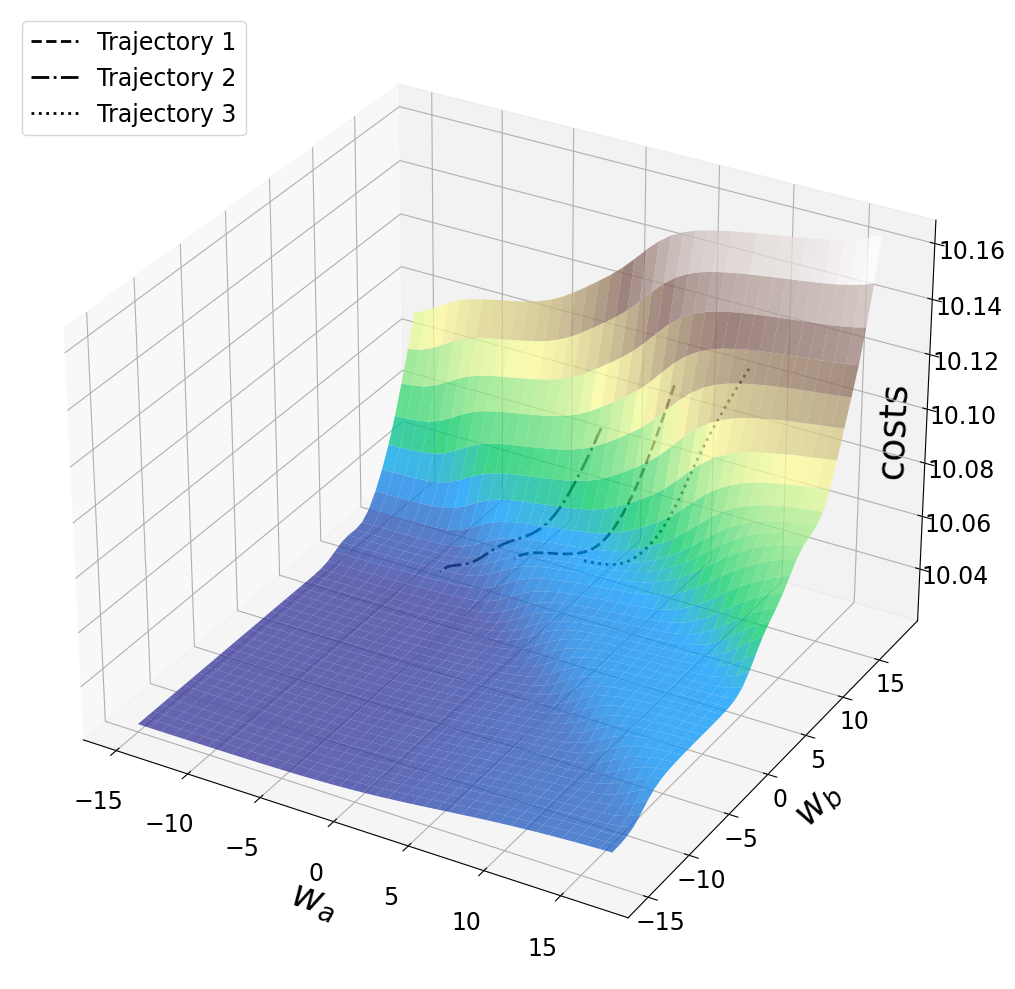

In [229]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Устанавливаем метки осей
ax.set_xlabel(r'$w_a$', fontsize=27, labelpad=17)
ax.set_ylabel(r'$w_b$', fontsize=27, labelpad=5)
ax.set_zlabel("costs", fontsize=27, labelpad=-35)
ax.tick_params(axis='x', pad=12, which='major', labelsize=17)
ax.tick_params(axis='y', pad=0, which='major', labelsize=17)
ax.tick_params(axis='z', pad=8, which='major', labelsize=17)


# Строим поверхность (loss landscape)
ax.plot_surface(M1, M2, Z_100, cmap='terrain', antialiased=True, cstride=1, rstride=1, alpha=0.75)

# Строим траектории градиентного спуска
line_style = ["dashed", "dashdot", "dotted"]  # Линии для траекторий
for j in range(3):  # Проходим по каждой траектории
    ax.plot(weights_2_5_250[j], weights_2_5_251[j], costs[j],
            linestyle=line_style[j], linewidth=2, color="black", label=f'Trajectory {j+1}')


# Отображаем легенду
ax.legend(loc='upper left', fontsize=17)
plt.tight_layout()
plt.show()

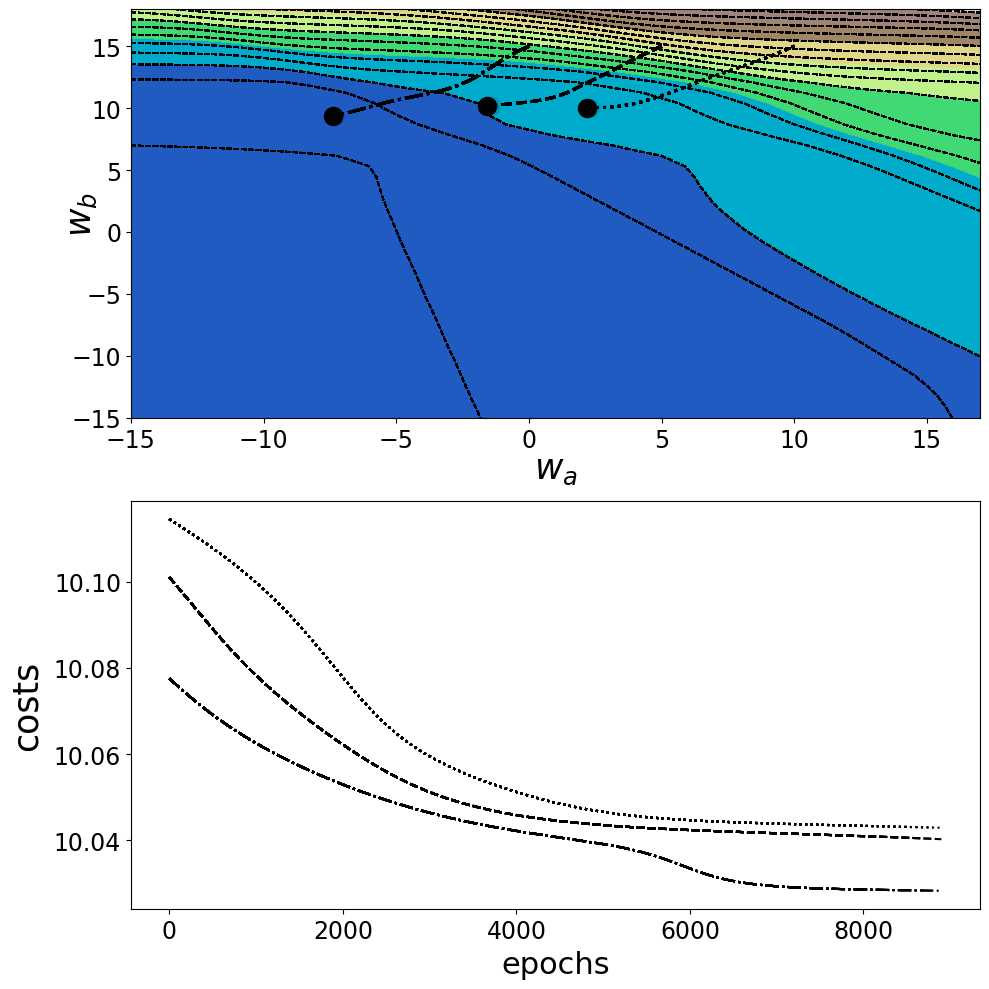

In [228]:
fig = plt.figure(figsize=(10,10)) # create figure
ax0=fig.add_subplot(2, 1, 1)
ax1=fig.add_subplot(2, 1, 2)

# Customize subplots:
ax0.set_xlabel(r'$w_a$', fontsize=25, labelpad=0)
ax0.set_ylabel(r'$w_b$', fontsize=25, labelpad=-20)
ax0.tick_params(axis='both', which='major', labelsize=17)
ax1.set_xlabel("epochs", fontsize=22, labelpad=5)
ax1.set_ylabel("costs", fontsize=25, labelpad=7)
ax1.tick_params(axis='both', which='major', labelsize=17)

contours_=21 # set the number of contour lines
points_=np.arange(0,9000,100) # define which epochs to plot

for i in points_:
    cf=ax0.contour(M1, M2, Z_100,contours_, colors='black', # contour plot
                     linestyles='dashed', linewidths=1)
    ax0.contourf(M1, M2, Z_100, alpha=0.85,cmap='terrain') # filled contour plots

    for j in range(3):
        ax0.scatter(weights_2_5_250[j][i],weights_2_5_251[j][i],marker='o', s=13**2,
               color="black", alpha=1.0)
        ax0.plot(weights_2_5_250[j][0:i],weights_2_5_251[j][0:i],
                linestyle=line_style[j],linewidth=2,
                color="black", label=str(i))

        ax1.plot(costs[j][0:i], color="black", linestyle=line_style[j])
    plt.tight_layout()




Траектория поиска минимума стала более гладкая.